$
\newcommand{\set}[2]{\big\{#1\,\ {\large:}\ \,#2\big\}}
\newcommand{\eps}{\varepsilon}
\newcommand{\abs}[1]{\left\vert#1\right\vert}
\newcommand{\ceil}[1]{\left\lceil#1\right\rceil}
\newcommand{\floor}[1]{\left\lfloor#1\right\rfloor}
\newcommand{\vphi}{\varphi}
\DeclareMathOperator{\sinal}{sinal}
$
# O método de Newton

## $ \S 1 $ Descrição do método de Newton

Suponha que desejemos encontrar um zero de uma função *diferenciável* $ f $. Partindo de uma estimativa inicial $ x_0 $, a idéia por trás do **método de Newton** é substituir a função pela sua reta tangente na estimativa atual $ x_n $ e tomar a  intersecção desta com o eixo-$x$ como o valor da próxima estimativa $ x_{n + 1} $. 

Em símbolos, a reta tangente ao gráfico de $ f $ em $ x_n $ é descrita pela equação:
$$
y = f(x_n) + f'(x_n)\,(x - x_{n})\,.
$$
Fazendo $ y = 0 $, encontramos que a aproximação $ x_{n + 1} $ seguinte é dada por
$$
\boxed{x_{n + 1} = x_n - \frac{f(x_n)}{f'(x_n)}}
$$

## $ \S 2 $ Vantagens e desvantagens do método de Newton

No método de Newton o erro cometido na iteração seguinte é aproximadamente proporcional ao *quadrado* do erro da iteração atual. Portanto podemos esperar que uma vez que o erro seja menor que $ 0.1 $, a cada passo o número de dígitos decimais de precisão dobrará. Este desempenho deve ser comparado com o do método da bisseção, em que o erro seguinte é aproximadamente proporcional ao erro atual (por um fator de $ 1/2 $). Informalmente, isto significa que uma vez que consigamos uma estimativa próxima o suficiente de um zero, o método de Newton convergirá muito mais rapidamente que os outros métodos que estudamos. Outra vantagem é que para aplicar o método de Newton, não precisamos encaixotar o zero.

Entretanto, o método de Newton tem duas desvantagens significativas:
* Ele exige o cálculo da derivada da função à qual será aplicado.
* Ele nem sempre funciona, ou seja, a seqüência $ (x_n) $ pode não convergir.

Por estes motivos uma estratégia mais adequada é utilizar o método de Newton em combinação com um mais confiável, como o método da bissecção.

**Problema 1:** Sem usar o computador, aplique o método de Newton para estimar um zero das funções abaixo, usando a estimativa inicial $ x_0 $ e o número de iterações $ N $ indicados:

(a) $ y = xe^x - 1\, ,\quad  x_0 = \frac{1}{2}\, , \quad  N = 3\, $. 

(b) $ y = \arctan x\, ,\quad  x_0 = 1\, , \quad  N = 4\, $. 

(c) $ y = \ln x - 3\, ,\quad  x_0 = 10\, , \quad  N = 4\, $. 


       n       x             y            
----------------------------------------------
      00      0.00000       1.00000
      01      1.00000       2.00000
      02      0.77778       0.79148
      03      0.48017       0.57088
      04      1.69899      27.61388
--------------------------------------------------


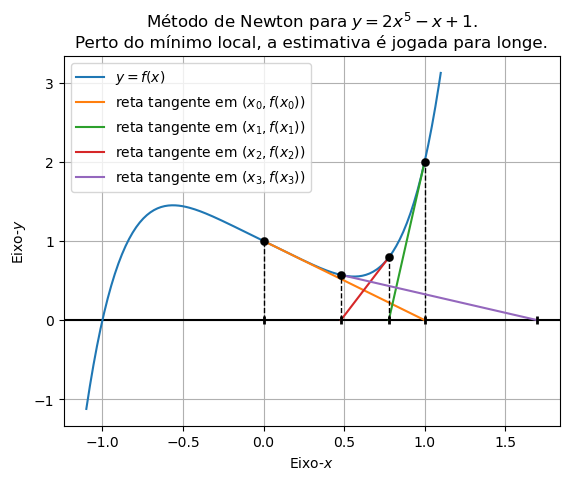

In [166]:
def visualizador_metodo_newton(f, df, a, b, x_0, N):
    """
    """
    import matplotlib.pyplot as plt
    import numpy as np
        

    def reta_tangente_em(x_0):
        return lambda x: f(x_0) + df(x_0) * (x - x_0)


    itera = lambda x: x - f(x) / df(x)
    P = 200
    xs = [x_0]
    for _ in range(N):
        xs.append(itera(xs[-1]))
    ys = [f(x) for x in xs]
    retas_tangentes = [reta_tangente_em(x) for x in xs]

    dominio = np.linspace(a, b, P)
    xs_range = [np.linspace(xs[i], xs[i + 1], P) for i in range(N)]
    xs_vert = [np.linspace(xs[i], xs[i], P) for i in range(N)]
    ys_vert = [np.linspace(0, ys[i], P) for i in range(N)]

    plt.axhline(y=0.0, color='black', linestyle='-')#, label='eixo-$ x $')
    plt.plot(dominio, f(dominio), label='$ y = f(x) $')
    for i in range(N):
        plt.plot(xs_vert[i], ys_vert[i], linestyle='--', linewidth=1.0, color='black')
        plt.plot(xs_range[i], retas_tangentes[i](xs_range[i]),\
                 linestyle='-', label=f"reta tangente em $ (x_{i}, f(x_{i})) $")
        plt.plot(xs[i], 0, color='black', marker="|", mew=2.0)
        plt.plot(xs[i], ys[i], color='black', marker="o", mew=0.2)
    plt.plot(xs[-1], 0, color='black', marker="|", mew=2.0)
    plt.xlabel('Eixo-$ x $')
    plt.ylabel('Eixo-$ y $')
    plt.grid(True)
    plt.title("Método de Newton para $ y = 2x^5 - x + 1 $."\
              "\nPerto do mínimo local, a estimativa é jogada para longe.")
    plt.legend()
    return xs, ys
    

from numpy import arctan, sin, cos, exp
a = -1.1
b = 1.1
N = 4
f = lambda x: 2 * x**5 - x + 1
df = lambda x: 10 * x**4 - 1
x_0 = 0.0

xs, ys = visualizador_metodo_newton(f, df, a, b, x_0, N)
imprime_solucao(xs, ys)

In [165]:
def imprime_solucao(xs, ys, freq=1):
    """
    Dados dois arrays xs e ys de mesmo comprimento, imprime um
    a cada 'freq' de seus valores por linha, na forma de uma
    tabela. Os 0-ésimos e últimos valores sempre são impressos.
    """
    def imprime_cabecalho():
        """
        Imprime o cabeçalho da tabela.
        """
        print("\n       n       ", end="")
        print("x             ", end="")
        print(f"y            ")
        print("----------------------------------------------")
        
        
    def imprime_linha(x, y):
        """
        Imprime uma das linhas da tabela.
        """
        print(f"      {n:02}", end="")
        print(f"{x:13.5f}", end="")
        print(f" {y:13.5f}")
    
    
    N = len(ys) - 1        # N + 1 é o número de nodos; N o de passos.
    if freq == 0:          # Se freq == 0, imprime apenas os últimos valores.
        freq = N
    imprime_cabecalho()
    for n in range(0, N + 1, freq):
        imprime_linha(xs[n], ys[n])
    if n != N:
        imprime_linha(xs[N], ys[N])
    print("--------------------------------------------------")
        
    return None